In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats, torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam

## format data

In [2]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

div_pos = .0

# Define stimulus positions - create more data points
n_positions = 20  # Number of unique positions
n_samples_per_pos = 500  # Samples per position for better statistics
positions = np.linspace(-.39, .39, n_positions)

# Create expanded dataset with repetitions
X_expanded = np.tile(positions, n_samples_per_pos)  # Shape: (10000,)
Y_expanded = X_expanded.copy()  # Same values for Y
labels_expanded = (X_expanded > div_pos).astype(float)

# Stratified train/test split (80/20) - equal samples per position in each split
train_size_per_pos = int(0.8 * n_samples_per_pos)  # 40 samples per position for training
test_size_per_pos = n_samples_per_pos - train_size_per_pos  # 10 samples per position for testing

train_indices = []
test_indices = []

for i, pos in enumerate(positions):
    # Get indices for this position
    pos_indices = np.where(X_expanded == pos)[0]
    
    # Randomly shuffle indices for this position
    pos_indices_shuffled = np.random.permutation(pos_indices)
    
    # Split for this position
    train_indices.extend(pos_indices_shuffled[:train_size_per_pos])
    test_indices.extend(pos_indices_shuffled[train_size_per_pos:])

# Convert to numpy arrays
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

# Split data
X_train = X_expanded[train_indices]
Y_train = Y_expanded[train_indices]
labels_train = labels_expanded[train_indices]

X_test = X_expanded[test_indices]
Y_test = Y_expanded[test_indices]
labels_test = labels_expanded[test_indices]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(1)
Y_train_tensor = torch.from_numpy(Y_train).float().unsqueeze(1)
labels_train_tensor = torch.from_numpy(labels_train).float().unsqueeze(1)

X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(1)
Y_test_tensor = torch.from_numpy(Y_test).float().unsqueeze(1)
labels_test_tensor = torch.from_numpy(labels_test).float().unsqueeze(1)

print(f"Generated {len(X_expanded)} total samples")
print(f"Training samples: {len(X_train)} ({train_size_per_pos} per position)")
print(f"Test samples: {len(X_test)} ({test_size_per_pos} per position)")
print(f"X range: [{X_expanded.min():.3f}, {X_expanded.max():.3f}]")
print(f"Unique X positions in train: {len(np.unique(X_train))}")
print(f"Unique X positions in test: {len(np.unique(X_test))}")

# Verify stratification
print("\nVerifying equal representation:")
for pos in positions[:3]:  # Check first 3 positions as example
    train_count = np.sum(X_train == pos)
    test_count = np.sum(X_test == pos)
    print(f"Position {pos:.3f}: {train_count} train, {test_count} test")

Generated 10000 total samples
Training samples: 8000 (400 per position)
Test samples: 2000 (100 per position)
X range: [-0.390, 0.390]
Unique X positions in train: 20
Unique X positions in test: 20

Verifying equal representation:
Position -0.390: 400 train, 100 test
Position -0.349: 400 train, 100 test
Position -0.308: 400 train, 100 test


## setup model

In [16]:
# Hyperparameters
divider_position = 0.0
boundary_width   = 0.05
learning_rate    = 1e-3
batch_size       = 16  # Smaller batch size for better gradient estimates
num_epochs       = 100  # Reduced epochs since we have more data

# Store test predictions every N epochs for analysis
test_predictions_history = []
test_epoch_interval = 1  # Store predictions every 1 epoch

# Define the model architecture with position-dependent embedding noise
class NoisyModel(nn.Module):
    def __init__(self, max_embedding_noise=0.2, production_noise=0.05, noise_range=0.4):
        super().__init__()
        self.linear1 = nn.Linear(1, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 1)
        self.max_embedding_noise = max_embedding_noise
        self.production_noise = production_noise
        self.noise_range = noise_range  # Range within which noise decreases
        
        # Better initialization for wider output range
        with torch.no_grad():
            self.linear2.weight.data *= 2.0  # Scale up final layer weights
    
    def _compute_embedding_noise_magnitude(self, x):
        """Compute position-dependent noise magnitude based on distance from 0"""
        # Calculate noise magnitude: high at x=0, decreases to 0 at boundaries
        noise_magnitude = torch.maximum(
            torch.zeros_like(x), 
            self.max_embedding_noise * (1 - torch.abs(x) / self.noise_range)
        )
        return noise_magnitude
        
    def forward(self, x):
        # Compute position-dependent embedding noise
        embedding_noise_mag = self._compute_embedding_noise_magnitude(x)
        
        # First layer
        hidden = self.linear1(x)  # Shape: (batch_size, 16)
        
        # Add position-dependent noise to embeddings
        # Expand noise magnitude to match hidden dimensions
        noise_mag_expanded = embedding_noise_mag.expand(-1, hidden.size(1))  # Shape: (batch_size, 16)
        noise = torch.randn_like(hidden) * noise_mag_expanded
        hidden = hidden + noise
        hidden = self.relu(hidden)
        
        # Output layer
        output = self.linear2(hidden)  # Shape: (batch_size, 1)
        output = output + torch.randn_like(output) * self.production_noise
        
        return output

# Create model with position-dependent embedding noise
model = NoisyModel(max_embedding_noise=.6, production_noise=.3, noise_range=.4)


# Prepare data loaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, labels_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor, labels_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer & history
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # regularization
history = {'train_mse': [], 'train_bce': [], 'train_total': [], 'train_accuracy': [],
          'test_mse': [], 'test_bce': [], 'test_total': [], 'test_accuracy': []}


## viz embedding noise

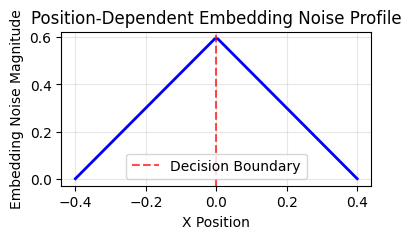

Max noise at x=0: 0.6
Noise at x=±0.4: 0.000


In [17]:
# Visualize the position-dependent noise profile
x_test_range = torch.linspace(-0.4, 0.4, 100).unsqueeze(1)
with torch.no_grad():
    noise_magnitudes = model._compute_embedding_noise_magnitude(x_test_range)

plt.figure(figsize=(4, 2))
plt.plot(x_test_range.squeeze(), noise_magnitudes.squeeze(), 'b-', linewidth=2)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
plt.xlabel('X Position')
plt.ylabel('Embedding Noise Magnitude')
plt.title('Position-Dependent Embedding Noise Profile')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Max noise at x=0: {model.max_embedding_noise}")
print(f"Noise at x=±0.4: {model._compute_embedding_noise_magnitude(torch.tensor([[0.4]])).item():.3f}")

## training

In [18]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_mse = 0.0
    epoch_train_bce = 0.0
    epoch_train_accuracy = 0.0
    epoch_train_total = 0.0

    for inputs, targets, class_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Per-sample losses
        per_sample_mse = (outputs - targets).pow(2)
        per_sample_bce = F.binary_cross_entropy_with_logits(
            outputs, class_labels, reduction='none'
        )

        # Loss weighting
        classification_weight = .0
        mse_weight = 1.0
        
        batch_loss = (mse_weight * per_sample_mse + 
                      classification_weight * per_sample_bce).mean()
        
        batch_loss.backward()
        optimizer.step()

        # Accumulate training metrics
        epoch_train_mse += per_sample_mse.mean().item()
        epoch_train_bce += per_sample_bce.mean().item()
        epoch_train_total += batch_loss.item()
        epoch_train_accuracy += (
            outputs.sigmoid().gt(0.5) == class_labels
        ).float().mean().item()

    # Evaluation phase
    model.eval()
    epoch_test_mse = 0.0
    epoch_test_bce = 0.0
    epoch_test_accuracy = 0.0
    epoch_test_total = 0.0
    
    with torch.no_grad():
        for inputs, targets, class_labels in test_loader:
            outputs = model(inputs)
            
            per_sample_mse = (outputs - targets).pow(2)
            per_sample_bce = F.binary_cross_entropy_with_logits(
                outputs, class_labels, reduction='none'
            )
            
            batch_loss = (mse_weight * per_sample_mse + 
                          classification_weight * per_sample_bce).mean()
            
            epoch_test_mse += per_sample_mse.mean().item()
            epoch_test_bce += per_sample_bce.mean().item()
            epoch_test_total += batch_loss.item()
            epoch_test_accuracy += (
                outputs.sigmoid().gt(0.5) == class_labels
            ).float().mean().item()
    
    # Store history
    num_train_batches = len(train_loader)
    num_test_batches = len(test_loader)
    
    history['train_mse'].append(epoch_train_mse / num_train_batches)
    history['train_bce'].append(epoch_train_bce / num_train_batches)
    history['train_total'].append(epoch_train_total / num_train_batches)
    history['train_accuracy'].append(epoch_train_accuracy / num_train_batches)
    
    history['test_mse'].append(epoch_test_mse / num_test_batches)
    history['test_bce'].append(epoch_test_bce / num_test_batches)
    history['test_total'].append(epoch_test_total / num_test_batches)
    history['test_accuracy'].append(epoch_test_accuracy / num_test_batches)
    
    # Store test predictions periodically
    if epoch % test_epoch_interval == 0 or epoch == num_epochs - 1:
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_predictions_history.append({
                'epoch': epoch,
                'X_test': X_test.copy(),
                'Y_test': Y_test.copy(),
                'Y_pred': test_outputs.squeeze().numpy().copy(),
                'labels_test': labels_test.copy()
            })

print(f"Training completed. Collected {len(test_predictions_history)} test prediction snapshots.")

Training completed. Collected 100 test prediction snapshots.


## collate data

In [19]:
# Collate all test predictions across epochs for richer analysis
all_test_data = []

for pred_snapshot in test_predictions_history:
    epoch = pred_snapshot['epoch']
    X_test_epoch = pred_snapshot['X_test']
    Y_test_epoch = pred_snapshot['Y_test']
    Y_pred_epoch = pred_snapshot['Y_pred']
    labels_test_epoch = pred_snapshot['labels_test']
    
    # Create DataFrame for this epoch
    epoch_df = pd.DataFrame({
        'epoch': epoch,
        'X': X_test_epoch,
        'Y_true': Y_test_epoch,
        'Y_pred': Y_pred_epoch,
        'class_pred': (Y_pred_epoch > 0).astype(int),
        'class_true': labels_test_epoch.astype(int),
    })
    all_test_data.append(epoch_df)

# Combine all test data
df_all_test = pd.concat(all_test_data, ignore_index=True)

# Also create final epoch data for detailed analysis
final_snapshot = test_predictions_history[-1]
df_final = pd.DataFrame({
    'X': final_snapshot['X_test'],
    'Y_true': final_snapshot['Y_test'],
    'Y_pred': final_snapshot['Y_pred'],
    'class_pred': (final_snapshot['Y_pred'] > 0).astype(int),
    'class_true': final_snapshot['labels_test'].astype(int),
})

print(f"All test data shape: {df_all_test.shape}")
print(f"Final epoch data shape: {df_final.shape}")
print(f"Number of unique epochs: {df_all_test['epoch'].nunique()}")
print(f"Test points per epoch: {len(df_final)}")
print("\nSample of all test data:")
print(df_all_test.head(10))

All test data shape: (200000, 6)
Final epoch data shape: (2000, 5)
Number of unique epochs: 100
Test points per epoch: 2000

Sample of all test data:
   epoch     X  Y_true    Y_pred  class_pred  class_true
0      0 -0.39   -0.39 -0.404403           0           0
1      0 -0.39   -0.39  0.070921           1           0
2      0 -0.39   -0.39 -0.278733           0           0
3      0 -0.39   -0.39 -0.191236           0           0
4      0 -0.39   -0.39 -0.162268           0           0
5      0 -0.39   -0.39 -0.437052           0           0
6      0 -0.39   -0.39 -0.244489           0           0
7      0 -0.39   -0.39 -0.155467           0           0
8      0 -0.39   -0.39 -0.532344           0           0
9      0 -0.39   -0.39 -0.131063           0           0


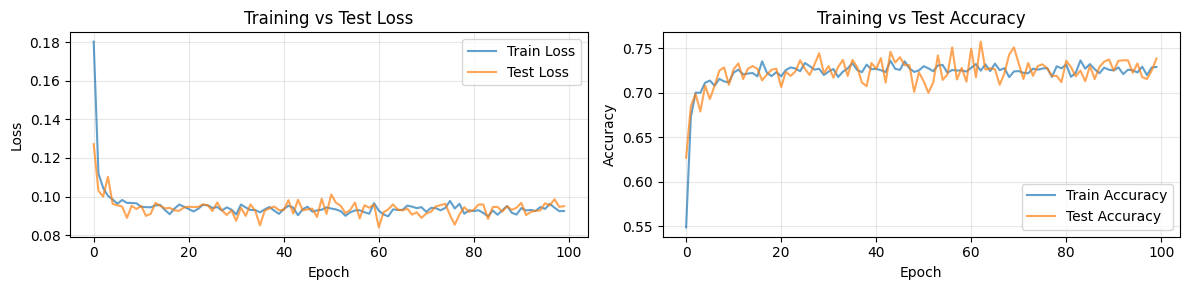

Total test predictions collected: 200000
Final test accuracy: 0.739


In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs, ax = axs.flatten(), 0

# Plot 1: Training curves
axs[ax].plot(history['train_total'], label='Train Loss', alpha=0.7)
axs[ax].plot(history['test_total'], label='Test Loss', alpha=0.7)
axs[ax].set_xlabel('Epoch')
axs[ax].set_ylabel('Loss')
axs[ax].set_title('Training vs Test Loss')
axs[ax].legend()
axs[ax].grid(True, alpha=0.3)
ax += 1

# Plot 2: Accuracy curves
axs[ax].plot(history['train_accuracy'], label='Train Accuracy', alpha=0.7)
axs[ax].plot(history['test_accuracy'], label='Test Accuracy', alpha=0.7)
axs[ax].set_xlabel('Epoch')
axs[ax].set_ylabel('Accuracy')
axs[ax].set_title('Training vs Test Accuracy')
axs[ax].legend()
axs[ax].grid(True, alpha=0.3)
ax += 1

plt.tight_layout()
plt.show()

print(f"Total test predictions collected: {len(df_all_test)}")
print(f"Final test accuracy: {history['test_accuracy'][-1]:.3f}")

## viz behavior

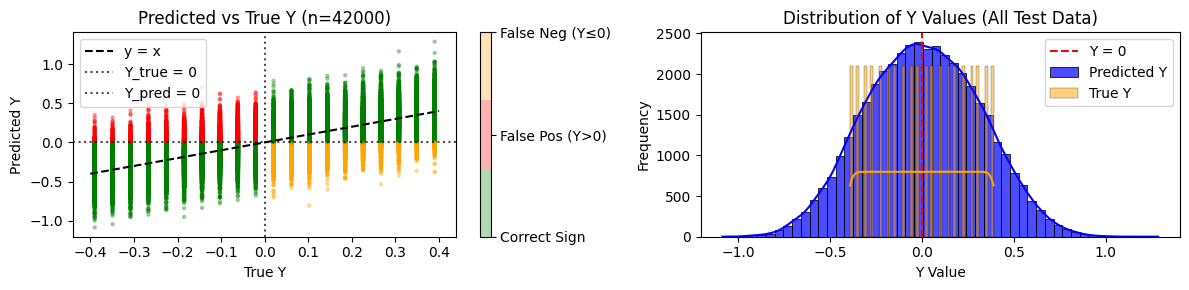

Total test predictions analyzed: 42000
Sign Classification Accuracy: 0.792
False Positive Rate: 0.107
False Negative Rate: 0.101
MSE: 0.0432
MAE: 0.1657


In [ ]:
# Use the richer dataset (all test predictions across epochs) for analysis
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Create correctness categories based on REGRESSION outputs crossing 0
true_class_regression = (df_all_test['Y_true'] > 0).astype(int)
pred_class_regression = (df_all_test['Y_pred'] > 0).astype(int)

# Classification performance based on regression crossing 0
correct_mask = (pred_class_regression == true_class_regression)
false_positive_mask = (pred_class_regression == 1) & (true_class_regression == 0)
false_negative_mask = (pred_class_regression == 0) & (true_class_regression == 1)

# Create color array
color_array = np.zeros(len(df_all_test))
color_array[false_positive_mask] = 1
color_array[false_negative_mask] = 2

# Define custom colormap
from matplotlib.colors import ListedColormap
colors = ['green', 'red', 'orange']
cmap = ListedColormap(colors)

# Plot 1: y_pred vs y_true (now with much more data)
sc1 = axs[0].scatter(df_all_test['Y_true'], df_all_test['Y_pred'], 
                     c=color_array, cmap=cmap, alpha=0.3, s=5)
axs[0].plot([-0.4, 0.4], [-0.4, 0.4], 'k--', label='y = x')
axs[0].axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Y_true = 0')
axs[0].axhline(y=0, color='black', linestyle=':', alpha=0.7, label='Y_pred = 0')
axs[0].set_xlabel('True Y')
axs[0].set_ylabel('Predicted Y')
axs[0].set_title(f'Predicted vs True Y (n={len(df_all_test)})')
# ...existing colorbar and legend code...
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_ticks([0, 1, 2])
cbar1.set_ticklabels(['Correct Sign', 'False Pos (Y>0)', 'False Neg (Y≤0)'])
axs[0].legend()

# Plot 2: Distribution comparison
sns.histplot(df_all_test['Y_pred'], bins=50, kde=True, color='blue', 
             label='Predicted Y', ax=axs[1], alpha=0.7)
sns.histplot(df_all_test['Y_true'], bins=50, kde=True, color='orange', 
             label='True Y', ax=axs[1], alpha=0.5)
axs[1].axvline(x=0, color='red', linestyle='--', label='Y = 0')
axs[1].set_xlabel('Y Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Y Values (All Test Data)')
axs[1].legend()

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print(f"Total test predictions analyzed: {len(df_all_test)}")
print(f"Sign Classification Accuracy: {correct_mask.mean():.3f}")
print(f"False Positive Rate: {false_positive_mask.mean():.3f}")
print(f"False Negative Rate: {false_negative_mask.mean():.3f}")
print(f"MSE: {((df_all_test['Y_pred'] - df_all_test['Y_true'])**2).mean():.4f}")
print(f"MAE: {abs(df_all_test['Y_pred'] - df_all_test['Y_true']).mean():.4f}")

## viz embeddings

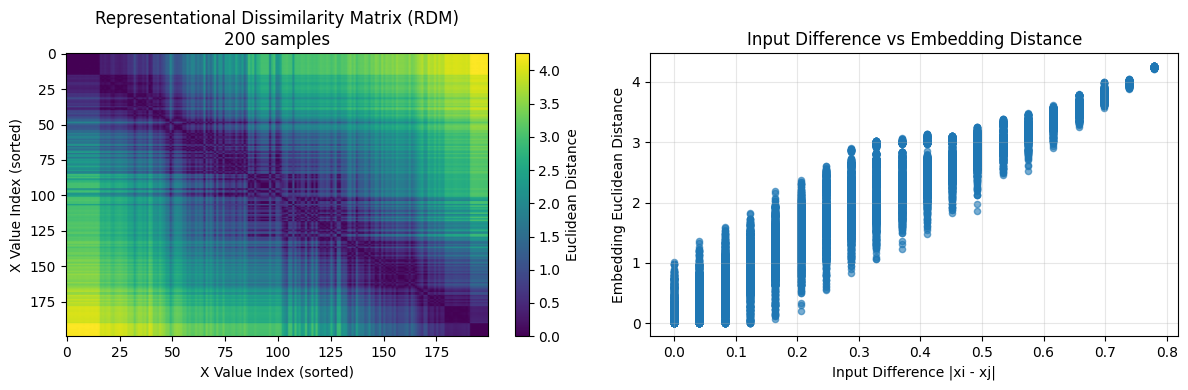

Embedding samples analyzed: 200
Embedding shape: (200, 16)
RDM shape: (200, 200)
Input range: [-0.390, 0.390]
Input difference range: [0.000, 0.780]
Embedding distance range: [0.000, 4.260]
Correlation between input and embedding distances: 0.955


In [ ]:
# Extract embeddings from the hidden layer
def get_embeddings(model, x_vals):
    """Extract hidden layer representations (embeddings) from the model."""
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for x in x_vals:
            x_tensor = torch.tensor([[x]], dtype=torch.float32)
            
            # Compute position-dependent embedding noise
            embedding_noise_mag = model._compute_embedding_noise_magnitude(x_tensor)
            
            # Get output from first layer
            hidden = model.linear1(x_tensor)  # First linear layer
            
            # Add the embedding noise (to match training behavior)
            noise_mag_expanded = embedding_noise_mag.expand(-1, hidden.size(1))
            noise = torch.randn_like(hidden) * noise_mag_expanded
            hidden = hidden + noise
            hidden = model.relu(hidden)       # ReLU activation
            
            embeddings.append(hidden.squeeze().numpy())
    
    return np.array(embeddings)

# Use a subset of the test data for embedding analysis
# Sample from the actual test set we have
n_embedding_samples = min(200, len(X_test))  # Use up to 200 samples
embedding_indices = np.random.choice(len(X_test), size=n_embedding_samples, replace=False)
x_embedding_test = X_test[embedding_indices]
x_embedding_test = np.sort(x_embedding_test)  # Sort for visualization

# Get embeddings for these X values
embeddings = get_embeddings(model, x_embedding_test)

# Compute pairwise Euclidean distances (RDM)
from scipy.spatial.distance import pdist, squareform
distances = pdist(embeddings, metric='euclidean')
rdm = squareform(distances)

# Compute input differences for scatter plot
input_diffs = []
embed_dists = []
for i in range(len(x_embedding_test)):
    for j in range(i+1, len(x_embedding_test)):
        input_diffs.append(abs(x_embedding_test[i] - x_embedding_test[j]))
        embed_dists.append(rdm[i, j])

# Plot the RDM and additional analysis
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# RDM heatmap
im = axs[0].imshow(rdm, cmap='viridis', aspect='auto')
axs[0].set_title(f'Representational Dissimilarity Matrix (RDM)\n{n_embedding_samples} samples')
axs[0].set_xlabel('X Value Index (sorted)')
axs[0].set_ylabel('X Value Index (sorted)')
fig.colorbar(im, ax=axs[0], label='Euclidean Distance')

# Plot input difference vs embedding distance
axs[1].scatter(input_diffs, embed_dists, alpha=0.6, s=20)
axs[1].set_xlabel('Input Difference |xi - xj|')
axs[1].set_ylabel('Embedding Euclidean Distance')
axs[1].set_title('Input Difference vs Embedding Distance')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Embedding samples analyzed: {n_embedding_samples}")
print(f"Embedding shape: {embeddings.shape}")
print(f"RDM shape: {rdm.shape}")
print(f"Input range: [{x_embedding_test.min():.3f}, {x_embedding_test.max():.3f}]")
print(f"Input difference range: [{min(input_diffs):.3f}, {max(input_diffs):.3f}]")
print(f"Embedding distance range: [{min(embed_dists):.3f}, {max(embed_dists):.3f}]")

# Additional analysis: correlation between input and embedding distances
correlation = np.corrcoef(input_diffs, embed_dists)[0, 1]
print(f"Correlation between input and embedding distances: {correlation:.3f}")